In [1]:
import polars as pl
import sqlite3
import plotly.express as px
import missingno as msno

import using polars (something new...)

In [2]:
jobs = pl.read_csv("lightcast_job_postings.csv")

In [3]:
print(jobs.shape)

(72476, 131)


In [4]:
print(jobs.columns)

['ID', 'LAST_UPDATED_DATE', 'LAST_UPDATED_TIMESTAMP', 'DUPLICATES', 'POSTED', 'EXPIRED', 'DURATION', 'SOURCE_TYPES', 'SOURCES', 'URL', 'ACTIVE_URLS', 'ACTIVE_SOURCES_INFO', 'TITLE_RAW', 'BODY', 'MODELED_EXPIRED', 'MODELED_DURATION', 'COMPANY', 'COMPANY_NAME', 'COMPANY_RAW', 'COMPANY_IS_STAFFING', 'EDUCATION_LEVELS', 'EDUCATION_LEVELS_NAME', 'MIN_EDULEVELS', 'MIN_EDULEVELS_NAME', 'MAX_EDULEVELS', 'MAX_EDULEVELS_NAME', 'EMPLOYMENT_TYPE', 'EMPLOYMENT_TYPE_NAME', 'MIN_YEARS_EXPERIENCE', 'MAX_YEARS_EXPERIENCE', 'IS_INTERNSHIP', 'SALARY', 'REMOTE_TYPE', 'REMOTE_TYPE_NAME', 'ORIGINAL_PAY_PERIOD', 'SALARY_TO', 'SALARY_FROM', 'LOCATION', 'CITY', 'CITY_NAME', 'COUNTY', 'COUNTY_NAME', 'MSA', 'MSA_NAME', 'STATE', 'STATE_NAME', 'COUNTY_OUTGOING', 'COUNTY_NAME_OUTGOING', 'COUNTY_INCOMING', 'COUNTY_NAME_INCOMING', 'MSA_OUTGOING', 'MSA_NAME_OUTGOING', 'MSA_INCOMING', 'MSA_NAME_INCOMING', 'NAICS2', 'NAICS2_NAME', 'NAICS3', 'NAICS3_NAME', 'NAICS4', 'NAICS4_NAME', 'NAICS5', 'NAICS5_NAME', 'NAICS6', 'NAIC

In [5]:
schema = pl.DataFrame({
    'Column': jobs.columns,
    'Data Type': jobs.dtypes,
    'Unique Values': [jobs.select(pl.col(col).n_unique()).item() for col in jobs.columns]
})

print(schema.shape)

(131, 3)


In [6]:
print(schema.head(20))

shape: (20, 3)
┌────────────────────────┬───────────┬───────────────┐
│ Column                 ┆ Data Type ┆ Unique Values │
│ ---                    ┆ ---       ┆ ---           │
│ str                    ┆ object    ┆ i64           │
╞════════════════════════╪═══════════╪═══════════════╡
│ ID                     ┆ String    ┆ 72476         │
│ LAST_UPDATED_DATE      ┆ String    ┆ 169           │
│ LAST_UPDATED_TIMESTAMP ┆ String    ┆ 174           │
│ DUPLICATES             ┆ Int64     ┆ 72            │
│ POSTED                 ┆ String    ┆ 153           │
│ …                      ┆ …         ┆ …             │
│ MODELED_DURATION       ┆ Int64     ┆ 61            │
│ COMPANY                ┆ Int64     ┆ 12303         │
│ COMPANY_NAME           ┆ String    ┆ 12302         │
│ COMPANY_RAW            ┆ String    ┆ 17214         │
│ COMPANY_IS_STAFFING    ┆ Boolean   ┆ 2             │
└────────────────────────┴───────────┴───────────────┘


some cleaning up first (round 1)...

In [7]:
columns_to_drop = [
    'ID', 'URL', 'ACTIVE_URLS', 'LAST_UPDATED_TIMESTAMP', 'DUPLICATES', 
    'NAICS2', 'NAICS2_NAME', 'NAICS3', 'NAICS3_NAME', 'NAICS4', 'NAICS4_NAME', 
    'NAICS5', 'NAICS5_NAME', 'NAICS6', 'NAICS6_NAME', 
    'SOC_2021_2', 'SOC_2021_2_NAME', 'SOC_2021_3', 'SOC_2021_3_NAME', 
    'SOC_2021_4', 'SOC_2021_4_NAME', 'SOC_2', 'SOC_2_NAME', 
    'SOC_3', 'SOC_3_NAME', 'SOC_4', 'SOC_4_NAME', 'SOC_5', 'SOC_5_NAME', 
    'NAICS_2022_2', 'NAICS_2022_2_NAME', 'NAICS_2022_3', 'NAICS_2022_3_NAME', 
    'NAICS_2022_4', 'NAICS_2022_4_NAME', 'NAICS_2022_5', 'NAICS_2022_5_NAME'
]

jobs_filtered = jobs.drop(columns_to_drop)

print(jobs_filtered.columns)

['LAST_UPDATED_DATE', 'POSTED', 'EXPIRED', 'DURATION', 'SOURCE_TYPES', 'SOURCES', 'ACTIVE_SOURCES_INFO', 'TITLE_RAW', 'BODY', 'MODELED_EXPIRED', 'MODELED_DURATION', 'COMPANY', 'COMPANY_NAME', 'COMPANY_RAW', 'COMPANY_IS_STAFFING', 'EDUCATION_LEVELS', 'EDUCATION_LEVELS_NAME', 'MIN_EDULEVELS', 'MIN_EDULEVELS_NAME', 'MAX_EDULEVELS', 'MAX_EDULEVELS_NAME', 'EMPLOYMENT_TYPE', 'EMPLOYMENT_TYPE_NAME', 'MIN_YEARS_EXPERIENCE', 'MAX_YEARS_EXPERIENCE', 'IS_INTERNSHIP', 'SALARY', 'REMOTE_TYPE', 'REMOTE_TYPE_NAME', 'ORIGINAL_PAY_PERIOD', 'SALARY_TO', 'SALARY_FROM', 'LOCATION', 'CITY', 'CITY_NAME', 'COUNTY', 'COUNTY_NAME', 'MSA', 'MSA_NAME', 'STATE', 'STATE_NAME', 'COUNTY_OUTGOING', 'COUNTY_NAME_OUTGOING', 'COUNTY_INCOMING', 'COUNTY_NAME_INCOMING', 'MSA_OUTGOING', 'MSA_NAME_OUTGOING', 'MSA_INCOMING', 'MSA_NAME_INCOMING', 'TITLE', 'TITLE_NAME', 'TITLE_CLEAN', 'SKILLS', 'SKILLS_NAME', 'SPECIALIZED_SKILLS', 'SPECIALIZED_SKILLS_NAME', 'CERTIFICATIONS', 'CERTIFICATIONS_NAME', 'COMMON_SKILLS', 'COMMON_SKILL

In [8]:
jobs_filtered.shape

(72476, 94)

In [9]:
nan_counts = jobs_filtered.null_count()
# looking at all columns

nan_counts_long = nan_counts.unpivot().rename({"variable": "Column", "value": "NaN Count"})

print(nan_counts_long.shape)

(94, 2)


In [10]:
print(nan_counts_long.head(20))

shape: (20, 2)
┌───────────────────────┬───────────┐
│ Column                ┆ NaN Count │
│ ---                   ┆ ---       │
│ str                   ┆ u32       │
╞═══════════════════════╪═══════════╡
│ LAST_UPDATED_DATE     ┆ 0         │
│ POSTED                ┆ 0         │
│ EXPIRED               ┆ 7822      │
│ DURATION              ┆ 27294     │
│ SOURCE_TYPES          ┆ 0         │
│ …                     ┆ …         │
│ EDUCATION_LEVELS      ┆ 0         │
│ EDUCATION_LEVELS_NAME ┆ 0         │
│ MIN_EDULEVELS         ┆ 0         │
│ MIN_EDULEVELS_NAME    ┆ 0         │
│ MAX_EDULEVELS         ┆ 56155     │
└───────────────────────┴───────────┘


<Axes: >

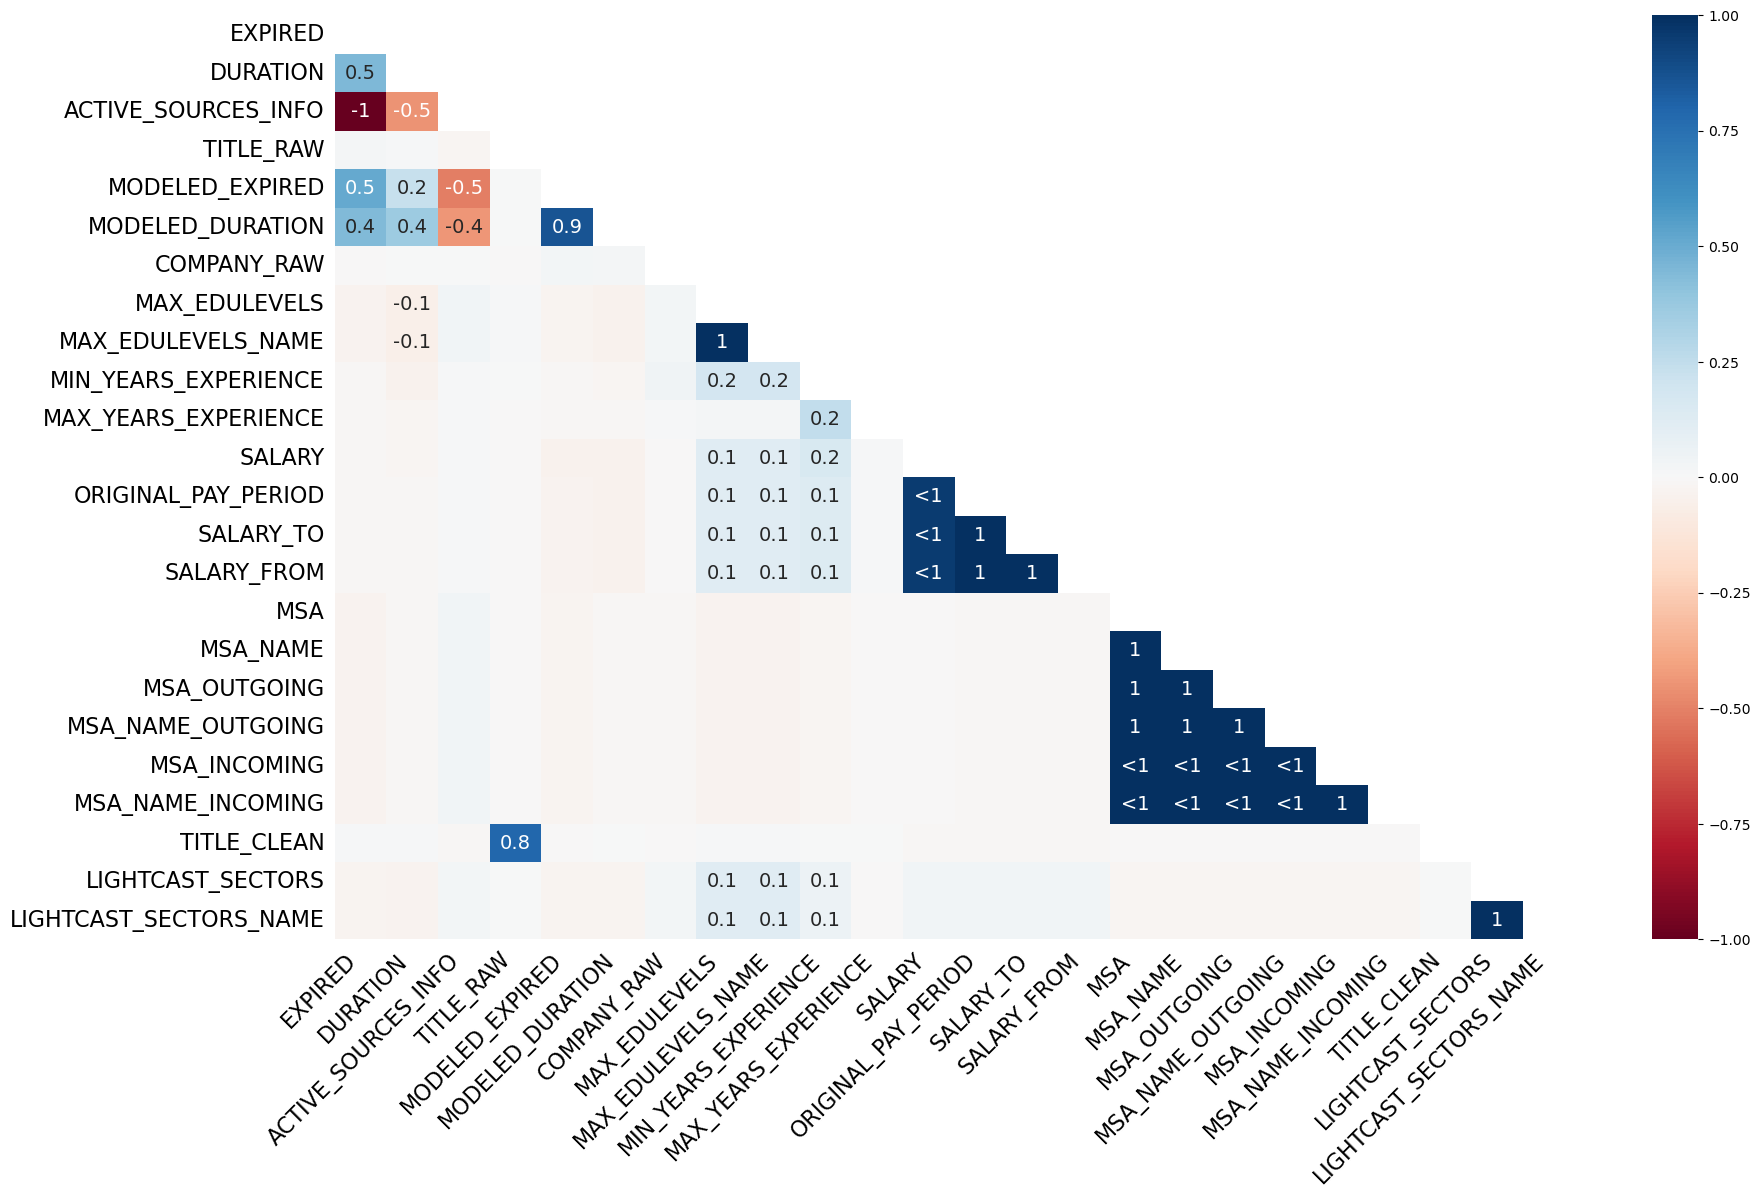

In [11]:
# testing the msno heatmap

jobs_filtered_pd = jobs_filtered.to_pandas()

msno.heatmap(jobs_filtered_pd)

In [12]:
# showing only columns with NaN values

nan_counts = jobs_filtered.null_count()
total_rows = jobs_filtered.height

nan_counts_filtered = (
    nan_counts.unpivot()
    .rename({"variable": "Column", "value": "NaN Count"})
    .filter(pl.col("NaN Count") > 0)
    .with_columns(
        (pl.col("NaN Count") / total_rows * 100).alias("NaN Percentage")
    )
)

print(nan_counts_filtered.to_pandas())

                    Column  NaN Count  NaN Percentage
0                  EXPIRED       7822       10.792538
1                 DURATION      27294       37.659363
2      ACTIVE_SOURCES_INFO      64654       89.207462
3                TITLE_RAW         60        0.082786
4          MODELED_EXPIRED      15383       21.224957
5         MODELED_DURATION      19261       26.575694
6              COMPANY_RAW        497        0.685744
7            MAX_EDULEVELS      56155       77.480821
8       MAX_EDULEVELS_NAME      56155       77.480821
9     MIN_YEARS_EXPERIENCE      23113       31.890557
10    MAX_YEARS_EXPERIENCE      64046       88.368563
11                  SALARY      41658       57.478338
12     ORIGINAL_PAY_PERIOD      40068       55.284508
13               SALARY_TO      40068       55.284508
14             SALARY_FROM      40068       55.284508
15                     MSA       3908        5.392130
16                MSA_NAME       3908        5.392130
17            MSA_OUTGOING  

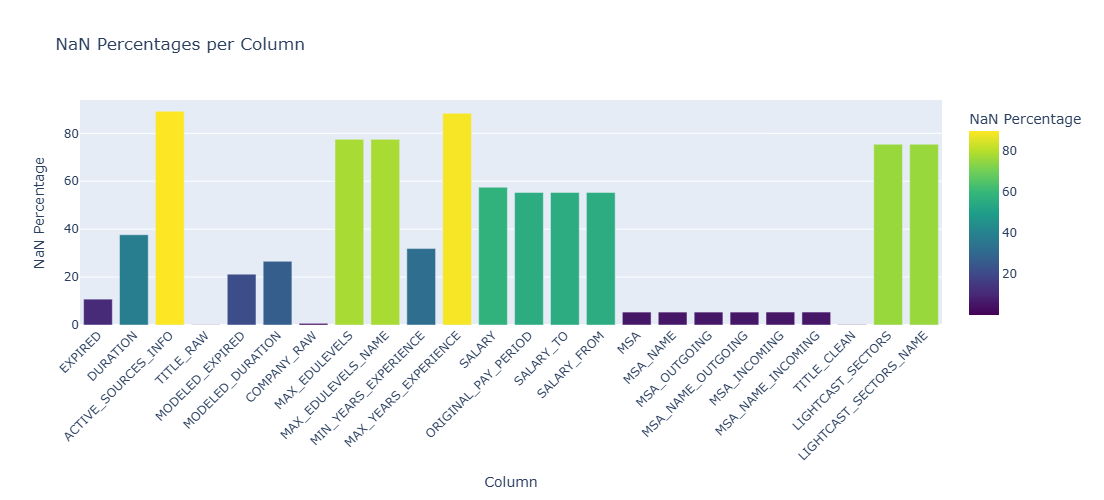

In [13]:
# visualize

nan_counts_filtered_pd = nan_counts_filtered.to_pandas()

fig = px.bar(
    nan_counts_filtered_pd,
    x="Column",
    y="NaN Percentage",
    color="NaN Percentage",
    title="NaN Percentages per Column",
    color_continuous_scale="Viridis"
)

fig.update_layout(width=1200, height=500, xaxis_tickangle=-45)
fig.show()

a bit more cleaning up (round 2)...

In [14]:
# removing columns comprised of 50% or higher NaN values (except SALARY, SALARY_FROM, SALARY_TO)

columns_to_drop = [
    "ACTIVE_SOURCES_INFO", "MAX_EDULEVELS", "MAX_EDULEVELS_NAME", "MAX_YEARS_EXPERIENCE", 
    "ORIGINAL_PAY_PERIOD", "LIGHTCAST_SECTORS", "LIGHTCAST_SECTORS_NAME"
]

jobs_filtered_2 = jobs_filtered.drop(columns_to_drop)

In [15]:
print(jobs_filtered_2.shape)

(72476, 87)


In [16]:
# and also remove duplicates

jobs_filtered_2 = jobs_filtered_2.unique(subset=["TITLE", "COMPANY", "LOCATION", "POSTED"], keep="first")

In [17]:
print(jobs_filtered_2.shape)

(69200, 87)


In [18]:
nan_counts = jobs_filtered_2.null_count()
total_rows = jobs_filtered_2.height 

nan_counts_filtered = (
    nan_counts.unpivot()
    .rename({"variable": "Column", "value": "NaN Count"})
    .filter(pl.col("NaN Count") > 0)  
    .with_columns(
        (pl.col("NaN Count") / total_rows * 100).alias("NaN Percentage")
    )
)

print(nan_counts_filtered.to_pandas())

                  Column  NaN Count  NaN Percentage
0                EXPIRED       7462       10.783237
1               DURATION      26092       37.705202
2              TITLE_RAW         54        0.078035
3        MODELED_EXPIRED      14739       21.299133
4       MODELED_DURATION      18401       26.591040
5            COMPANY_RAW        489        0.706647
6   MIN_YEARS_EXPERIENCE      22339       32.281792
7                 SALARY      39954       57.736994
8              SALARY_TO      38490       55.621387
9            SALARY_FROM      38490       55.621387
10                   MSA       2806        4.054913
11              MSA_NAME       2806        4.054913
12          MSA_OUTGOING       2806        4.054913
13     MSA_NAME_OUTGOING       2806        4.054913
14          MSA_INCOMING       2816        4.069364
15     MSA_NAME_INCOMING       2816        4.069364
16           TITLE_CLEAN         88        0.127168


In [19]:
# insight into remote jobs

remote_type_series = jobs_filtered_2.get_column("REMOTE_TYPE_NAME")

value_counts = remote_type_series.value_counts(sort=True)

print(value_counts)

shape: (4, 2)
┌──────────────────┬───────┐
│ REMOTE_TYPE_NAME ┆ count │
│ ---              ┆ ---   │
│ str              ┆ u32   │
╞══════════════════╪═══════╡
│ [None]           ┆ 54211 │
│ Remote           ┆ 11745 │
│ Hybrid Remote    ┆ 2151  │
│ Not Remote       ┆ 1093  │
└──────────────────┴───────┘


go ahead with a SQL connection...

In [20]:
conn = sqlite3.connect(':memory:')

conn.execute("DROP TABLE IF EXISTS jobs;")

columns = ", ".join([f"{col} TEXT" for col in jobs_filtered_2.columns])
create_table_query = f"CREATE TABLE jobs ({columns});"
conn.execute(create_table_query)

insert_query = f"INSERT INTO jobs VALUES ({', '.join(['?'] * len(jobs_filtered_2.columns))})"

conn.executemany(insert_query, jobs_filtered_2.to_numpy().tolist())

conn.commit()

print("Data from jobs_filtered_2 has been successfully inserted into the SQLite database.")

Data from jobs_filtered_2 has been successfully inserted into the SQLite database.


In [21]:
query_count = """
SELECT COUNT(*) AS TotalCount
FROM jobs;
"""

cursor = conn.cursor()
cursor.execute(query_count)
result = cursor.fetchall()

total_count = pl.DataFrame(result, schema=["TotalCount"])

print(total_count)

shape: (1, 1)
┌────────────┐
│ TotalCount │
│ ---        │
│ i64        │
╞════════════╡
│ 69200      │
└────────────┘


*by NAICS_2022_6_NAME*

In [22]:
unique_naics_count = jobs_filtered_2.select(pl.col("NAICS_2022_6_NAME").n_unique()).to_numpy()

print(f"Unique NAICS_2022_6_NAME count: {unique_naics_count[0][0]}")

Unique NAICS_2022_6_NAME count: 814


In [23]:
# We're interseted in the finance, marketing, and transportation industries

query_filtered_naics_count = """
SELECT COUNT(DISTINCT NAICS_2022_6_NAME) AS Unique_NAICS_Count
FROM jobs
WHERE NAICS_2022_6_NAME LIKE '%finance%'
   OR NAICS_2022_6_NAME LIKE '%banking%'
   OR NAICS_2022_6_NAME LIKE '%investing%'
   OR NAICS_2022_6_NAME LIKE '%investments%'
   OR NAICS_2022_6_NAME LIKE '%marketing%'
   OR NAICS_2022_6_NAME LIKE '%transportation%';
"""

cursor = conn.cursor()
cursor.execute(query_filtered_naics_count)
result = cursor.fetchall()

unique_filtered_naics_count_df = pl.DataFrame(result, schema=["Unique_NAICS_Count"])

print(unique_filtered_naics_count_df)

shape: (1, 1)
┌────────────────────┐
│ Unique_NAICS_Count │
│ ---                │
│ i64                │
╞════════════════════╡
│ 28                 │
└────────────────────┘


In [24]:
pl.Config.set_tbl_rows(28)  

query_filtered_naics = """
SELECT DISTINCT NAICS_2022_6_NAME
FROM jobs
WHERE NAICS_2022_6_NAME LIKE '%finance%'
   OR NAICS_2022_6_NAME LIKE '%banking%'
   OR NAICS_2022_6_NAME LIKE '%investing%'
   OR NAICS_2022_6_NAME LIKE '%investments%'
   OR NAICS_2022_6_NAME LIKE '%marketing%'
   OR NAICS_2022_6_NAME LIKE '%transportation%';
"""

cursor = conn.cursor()
cursor.execute(query_filtered_naics)
result = cursor.fetchall()

filtered_naics_df = pl.DataFrame(result, schema=["NAICS_2022_6_NAME"], orient="row")

print(filtered_naics_df.shape)

(28, 1)


In [25]:
print(filtered_naics_df)

shape: (28, 1)
┌─────────────────────────────────┐
│ NAICS_2022_6_NAME               │
│ ---                             │
│ str                             │
╞═════════════════════════════════╡
│ Commercial Banking              │
│ Scheduled Passenger Air Transp… │
│ Telemarketing Bureaus and Othe… │
│ Investment Banking and Securit… │
│ Marketing Consulting Services   │
│ Freight Transportation Arrange… │
│ Regulation of Agricultural Mar… │
│ Marketing Research and Public … │
│ Special Needs Transportation    │
│ Regulation and Administration … │
│ Nonscheduled Chartered Freight… │
│ Scenic and Sightseeing Transpo… │
│ Other Support Activities for A… │
│ Public Finance Activities       │
│ Nonscheduled Chartered Passeng… │
│ Pipeline Transportation of Nat… │
│ School and Employee Bus Transp… │
│ Scheduled Freight Air Transpor… │
│ Pipeline Transportation of Cru… │
│ All Other Pipeline Transportat… │
│ Inland Water Freight Transport… │
│ Deep Sea Freight Transportatio… │
│ All Other T

In [26]:
#drop any filtered NAICS_2022_6_NAME(s) without salary information

query_avg_salary_by_filtered_naics = """
SELECT 
    NAICS_2022_6_NAME,
    COUNT(NAICS_2022_6_NAME) AS Occurrences,
    AVG(SALARY) AS Avg_Salary,
    AVG(SALARY_FROM) AS Avg_Salary_From,
    AVG(SALARY_TO) AS Avg_Salary_To
FROM jobs
WHERE SALARY IS NOT NULL AND SALARY_TO IS NOT NULL AND SALARY_FROM IS NOT NULL
  AND (NAICS_2022_6_NAME LIKE '%finance%'
   OR NAICS_2022_6_NAME LIKE '%banking%'
   OR NAICS_2022_6_NAME LIKE '%investing%'
   OR NAICS_2022_6_NAME LIKE '%investments%'
   OR NAICS_2022_6_NAME LIKE '%marketing%'
   OR NAICS_2022_6_NAME LIKE '%transportation%')
GROUP BY NAICS_2022_6_NAME
ORDER BY Occurrences DESC;
"""

cursor = conn.cursor()
cursor.execute(query_avg_salary_by_filtered_naics)
result = cursor.fetchall()

pl.Config.set_tbl_rows(28) 
pl.Config.set_tbl_cols(None) 

avg_salary_by_filtered_naics_df = pl.DataFrame(result, schema=["NAICS_2022_6_NAME", "Occurrences", "Avg_Salary", "Avg_Salary_From", "Avg_Salary_To"], orient="row")

print(avg_salary_by_filtered_naics_df.shape)

(23, 5)


In [27]:
# NOTE: drops 5

print(avg_salary_by_filtered_naics_df)

shape: (23, 5)
┌─────────────────────────────────┬─────────────┬───────────────┬─────────────────┬───────────────┐
│ NAICS_2022_6_NAME               ┆ Occurrences ┆ Avg_Salary    ┆ Avg_Salary_From ┆ Avg_Salary_To │
│ ---                             ┆ ---         ┆ ---           ┆ ---             ┆ ---           │
│ str                             ┆ i64         ┆ f64           ┆ f64             ┆ f64           │
╞═════════════════════════════════╪═════════════╪═══════════════╪═════════════════╪═══════════════╡
│ Commercial Banking              ┆ 922         ┆ 127314.572668 ┆ 103130.91757    ┆ 151398.733189 │
│ Telemarketing Bureaus and Othe… ┆ 201         ┆ 90259.129353  ┆ 72430.199005    ┆ 107765.024876 │
│ Investment Banking and Securit… ┆ 94          ┆ 120806.776596 ┆ 95981.223404    ┆ 144876.382979 │
│ Marketing Consulting Services   ┆ 48          ┆ 79475.604167  ┆ 69490.916667    ┆ 87989.833333  │
│ Regulation and Administration … ┆ 28          ┆ 93925.928571  ┆ 76147.75        ┆ 1

*by TITLE_NAME*

In [28]:
unique_title_count = jobs_filtered_2.select(pl.col("TITLE_NAME").n_unique()).to_numpy()

print(f"Unique TITLE_NAME count: {unique_title_count[0][0]}")

Unique TITLE_NAME count: 5720


In [29]:
# We're interested in analyst positions

pl.Config.set_tbl_rows(5000)

query_filtered_title = """
SELECT DISTINCT TITLE_NAME
FROM jobs
WHERE TITLE_NAME LIKE '%analyst%'
   OR TITLE_NAME LIKE '%analytics%'
   OR TITLE_NAME LIKE '%data%';
"""

cursor = conn.cursor()
cursor.execute(query_filtered_title)
result = cursor.fetchall()

filtered_title_df = pl.DataFrame(result, schema=["TITLE_NAME"], orient="row")

print(filtered_title_df.shape)

(1476, 1)


In [30]:
print(filtered_title_df.head(20))

shape: (20, 1)
┌────────────────────────────────┐
│ TITLE_NAME                     │
│ ---                            │
│ str                            │
╞════════════════════════════════╡
│ Data Analysts                  │
│ Oracle Analysts                │
│ Data Reporting Analysts        │
│ Data Management Analysts       │
│ Health Data Analysts           │
│ Lead Data Analysts             │
│ Customer Experience Analysts   │
│ Data Analytics Leads           │
│ WFM Analysts                   │
│ ERP Business Analysts          │
│ Business Intelligence Analysts │
│ Oracle Database Administrators │
│ Oracle Functional Analysts     │
│ Principal Data Scientists      │
│ Oracle Programmer Analysts     │
│ Enterprise Data Architects     │
│ Data and Reporting Analysts    │
│ ERP Systems Analysts           │
│ SAP Functional Analysts        │
│ Fraud Analysts                 │
└────────────────────────────────┘


In [31]:
#drop any filtered TITLE_NAMES(s) without salary information

query_avg_salary_by_filtered_title = """
SELECT 
    TITLE_NAME,
    COUNT(TITLE_NAME) AS Occurrences,
    AVG(SALARY) AS Avg_Salary,
    AVG(SALARY_FROM) AS Avg_Salary_From,
    AVG(SALARY_TO) AS Avg_Salary_To
FROM jobs
WHERE SALARY IS NOT NULL AND SALARY_TO IS NOT NULL AND SALARY_FROM IS NOT NULL
  AND (TITLE_NAME LIKE '%analyst%'
   OR TITLE_NAME LIKE '%analytics%'
   OR TITLE_NAME LIKE '%data%')
GROUP BY TITLE_NAME
ORDER BY Occurrences DESC;
"""

cursor = conn.cursor()
cursor.execute(query_avg_salary_by_filtered_title)
result = cursor.fetchall()

pl.Config.set_tbl_rows(1500) 
pl.Config.set_tbl_cols(None) 

avg_salary_by_filtered_title_df = pl.DataFrame(result, schema=["TITLE_NAME", "Occurrences", "Avg_Salary", "Avg_Salary_From", "Avg_Salary_To"], orient="row")

print(avg_salary_by_filtered_title_df.shape)

(1005, 5)


In [32]:
# NOTE: drops 471

print(avg_salary_by_filtered_title_df.head(20))

shape: (20, 5)
┌─────────────────────────────────┬─────────────┬───────────────┬─────────────────┬───────────────┐
│ TITLE_NAME                      ┆ Occurrences ┆ Avg_Salary    ┆ Avg_Salary_From ┆ Avg_Salary_To │
│ ---                             ┆ ---         ┆ ---           ┆ ---             ┆ ---           │
│ str                             ┆ i64         ┆ f64           ┆ f64             ┆ f64           │
╞═════════════════════════════════╪═════════════╪═══════════════╪═════════════════╪═══════════════╡
│ Data Analysts                   ┆ 3467        ┆ 93825.56533   ┆ 81035.9152      ┆ 106047.649841 │
│ Business Intelligence Analysts  ┆ 938         ┆ 103024.716418 ┆ 87234.638593    ┆ 118629.098081 │
│ Data Analytics Engineers        ┆ 325         ┆ 185512.461538 ┆ 161054.243077   ┆ 209111.68     │
│ Data and Reporting Analysts     ┆ 290         ┆ 79633.92069   ┆ 66126.458621    ┆ 91923.089655  │
│ Data Governance Analysts        ┆ 228         ┆ 111827.557018 ┆ 94360.548246    ┆ 1

now use both of the queries...

In [33]:
# Analyst positions within the Industries we're interested in

query_avg_salary_by_filtered_title_naics = """
SELECT 
    TITLE_NAME,
    NAICS_2022_6_NAME,
    COUNT(TITLE_NAME) AS Occurrences,
    AVG(SALARY) AS Avg_Salary,
    AVG(SALARY_FROM) AS Avg_Salary_From,
    AVG(SALARY_TO) AS Avg_Salary_To
FROM jobs
WHERE SALARY IS NOT NULL AND SALARY_TO IS NOT NULL AND SALARY_FROM IS NOT NULL
  AND (TITLE_NAME LIKE '%analyst%'
   OR TITLE_NAME LIKE '%analytics%'
   OR TITLE_NAME LIKE '%data%')
  AND (NAICS_2022_6_NAME LIKE '%finance%'
   OR NAICS_2022_6_NAME LIKE '%banking%'
   OR NAICS_2022_6_NAME LIKE '%investing%'
   OR NAICS_2022_6_NAME LIKE '%investments%'
   OR NAICS_2022_6_NAME LIKE '%marketing%'
   OR NAICS_2022_6_NAME LIKE '%transportation%')
GROUP BY TITLE_NAME, NAICS_2022_6_NAME
ORDER BY Occurrences DESC;
"""

cursor = conn.cursor()
cursor.execute(query_avg_salary_by_filtered_title_naics)
result = cursor.fetchall()

pl.Config.set_tbl_rows(250) 
pl.Config.set_tbl_cols(None) 

avg_salary_by_filtered_title_naics_df = pl.DataFrame(result, schema=["TITLE_NAME", "NAICS_2022_6_NAME", "Occurrences", "Avg_Salary", "Avg_Salary_From", "Avg_Salary_To"], orient="row")

print(avg_salary_by_filtered_title_naics_df.shape)

(244, 6)


In [34]:
# 244 remaining

print(avg_salary_by_filtered_title_naics_df.head(20))

shape: (20, 6)
┌─────────────────┬─────────────────┬─────────────┬───────────────┬────────────────┬───────────────┐
│ TITLE_NAME      ┆ NAICS_2022_6_NA ┆ Occurrences ┆ Avg_Salary    ┆ Avg_Salary_Fro ┆ Avg_Salary_To │
│ ---             ┆ ME              ┆ ---         ┆ ---           ┆ m              ┆ ---           │
│ str             ┆ ---             ┆ i64         ┆ f64           ┆ ---            ┆ f64           │
│                 ┆ str             ┆             ┆               ┆ f64            ┆               │
╞═════════════════╪═════════════════╪═════════════╪═══════════════╪════════════════╪═══════════════╡
│ Data and        ┆ Telemarketing   ┆ 65          ┆ 81366.523077  ┆ 64625.384615   ┆ 97198.0       │
│ Reporting       ┆ Bureaus and     ┆             ┆               ┆                ┆               │
│ Analysts        ┆ Othe…           ┆             ┆               ┆                ┆               │
│ Health Data     ┆ Telemarketing   ┆ 51          ┆ 94717.647059  ┆ 75764.70

plot 1

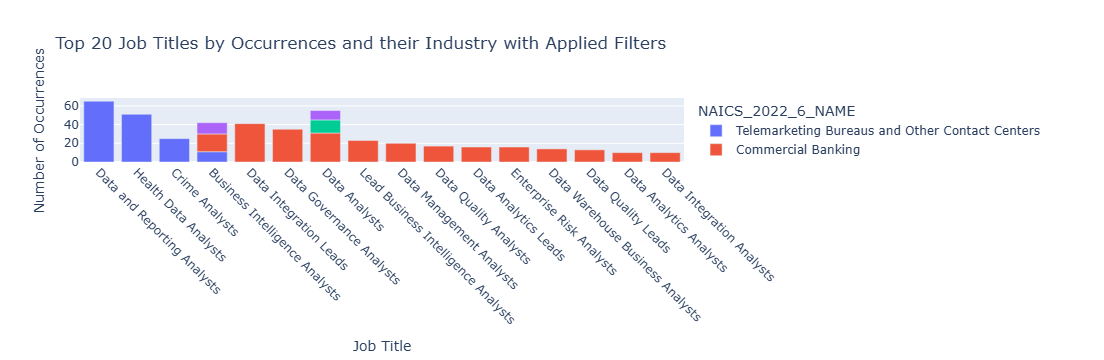

In [35]:
avg_salary_by_filtered_title_naics_df = pl.DataFrame(result, schema=["TITLE_NAME", "NAICS_2022_6_NAME", "Occurrences", "Avg_Salary", "Avg_Salary_From", "Avg_Salary_To"], orient="row")

avg_salary_by_filtered_title_naics_df_pd = avg_salary_by_filtered_title_naics_df.to_pandas()

top_20_df = avg_salary_by_filtered_title_naics_df_pd.head(20)

fig = px.bar(top_20_df, 
             x='TITLE_NAME', 
             y='Occurrences', 
             color='NAICS_2022_6_NAME', 
             title="Top 20 Job Titles by Occurrences and their Industry with Applied Filters",
             labels={'TITLE_NAME': 'Job Title', 'Occurrences': 'Number of Occurrences'},
             hover_data=['Avg_Salary', 'Avg_Salary_From', 'Avg_Salary_To'])

fig.update_layout(xaxis_tickangle=45)

fig.show()

plot 2

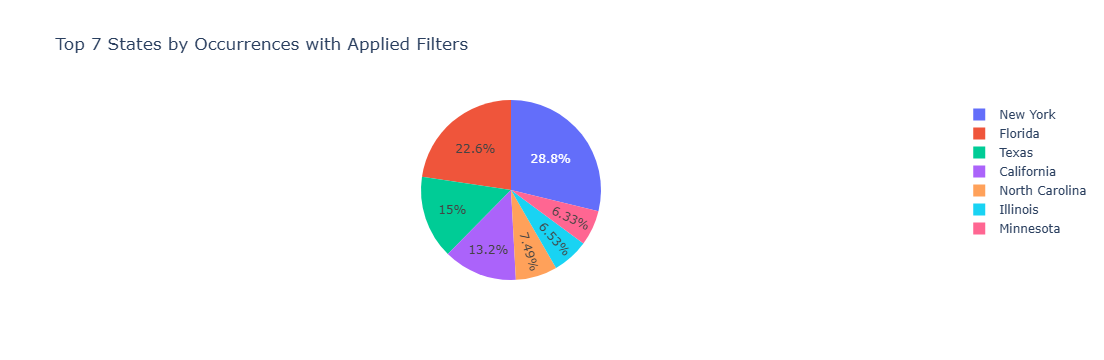

In [36]:
query_avg_salary_by_filtered_title_naics_state = """
SELECT 
    TITLE_NAME,
    NAICS_2022_6_NAME,
    STATE_NAME,
    COUNT(TITLE_NAME) AS Occurrences,
    AVG(SALARY) AS Avg_Salary,
    AVG(SALARY_FROM) AS Avg_Salary_From,
    AVG(SALARY_TO) AS Avg_Salary_To
FROM jobs
WHERE SALARY IS NOT NULL AND SALARY_TO IS NOT NULL AND SALARY_FROM IS NOT NULL
  AND (TITLE_NAME LIKE '%analyst%'
   OR TITLE_NAME LIKE '%analytics%'
   OR TITLE_NAME LIKE '%data%')
  AND (NAICS_2022_6_NAME LIKE '%finance%'
   OR NAICS_2022_6_NAME LIKE '%banking%'
   OR NAICS_2022_6_NAME LIKE '%investing%'
   OR NAICS_2022_6_NAME LIKE '%investments%'
   OR NAICS_2022_6_NAME LIKE '%marketing%'
   OR NAICS_2022_6_NAME LIKE '%transportation%')
GROUP BY STATE_NAME
ORDER BY Occurrences DESC
LIMIT 7;
"""

cursor = conn.cursor()
cursor.execute(query_avg_salary_by_filtered_title_naics_state)
result = cursor.fetchall()

pl.Config.set_tbl_rows(250) 
pl.Config.set_tbl_cols(None)

avg_salary_by_filtered_title_naics_state_df = pl.DataFrame(result, schema=["TITLE_NAME", "NAICS_2022_6_NAME", "STATE_NAME", "Occurrences", "Avg_Salary", "Avg_Salary_From", "Avg_Salary_To"], orient="row")

avg_salary_by_filtered_title_naics_state_df_pd = avg_salary_by_filtered_title_naics_state_df.to_pandas()


fig = px.pie(avg_salary_by_filtered_title_naics_state_df_pd,
             names='STATE_NAME',
             values='Occurrences',
             title="Top 7 States by Occurrences with Applied Filters",
             color='STATE_NAME')

fig.show()

plot 3

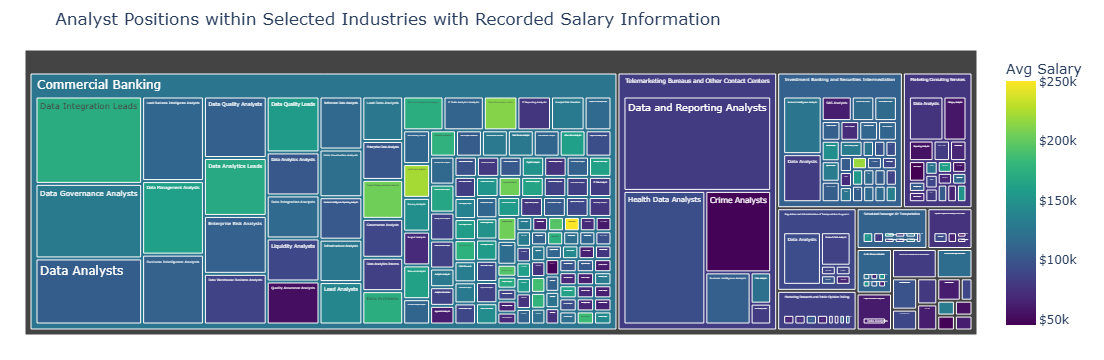

In [37]:
avg_salary_by_filtered_title_naics_df_pd = avg_salary_by_filtered_title_naics_df.to_pandas()

fig = px.treemap(
    avg_salary_by_filtered_title_naics_df_pd,
    path=['NAICS_2022_6_NAME', 'TITLE_NAME'], 
    values='Occurrences',                      
    color='Avg_Salary',                        
    color_continuous_scale='Viridis',       
    title='Analyst Positions within Selected Industries with Recorded Salary Information'
)

fig.update_layout(
    margin=dict(t=50, l=25, r=25, b=25),
    coloraxis_colorbar=dict(
        title="Avg Salary",
        tickprefix="$"
    )
)

fig.show()

In [38]:
conn.close()